In [12]:
from dataclasses import dataclass
from distribution import Categorical
from utils.common_funcs import get_unit_sigmoid_func
from markov_process import MarkovProcess, NonTerminal, State

@dataclass(frozen=True)
class StateMP3:
    num_up_moves: int
    num_down_moves: int

@dataclass(frozen=True)
class StockPriceMP3(MarkovProcess[StateMP3]):
    alpha3: float = 1.0 # strength of reverse-pull (non-negative value)

    def up_prob(self, state: StateMP3) -> float:
        total = state.num_up_moves + state.num_down_moves
        return get_unit_sigmoid_func(self.alpha3)(state.num_down_moves / total) if total else 0.5

    def transition(self, state: NonTerminal[StateMP3]) -> Categorical[State[StateMP3]]:
        up_p = self.up_prob(state.state)
        return Categorical({
            NonTerminal(StateMP3(state.state.num_up_moves + 1, state.state.num_down_moves)) : up_p,
            NonTerminal(StateMP3(state.state.num_up_moves, state.state.num_down_moves + 1)) : 1 - up_p
        })
    

In [10]:
import itertools
import numpy as np
from distribution import Constant

def process3_price_traces(start_price: int, alpha3: float, time_steps: int, num_traces: int) -> np.ndarray:
    mp = StockPriceMP3(alpha3=alpha3)
    start_state_distribution = Constant(NonTerminal(StateMP3(num_up_moves=0, num_down_moves=0)))
    return np.vstack([np.fromiter(
        (start_price + s.state.num_up_moves - s.state.num_down_moves for s in itertools.islice(mp.simulate(start_state_distribution), time_steps + 1)),float) 
        for _ in range(num_traces)
    ])

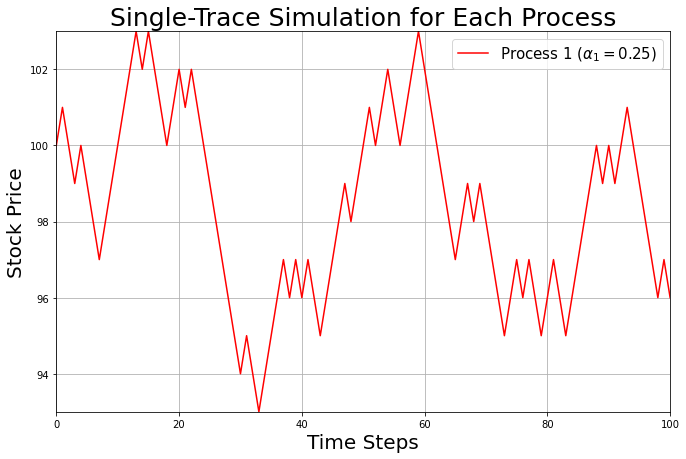

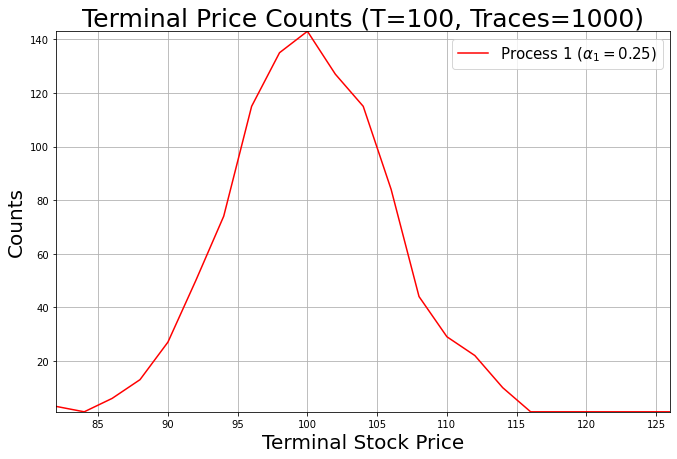

In [14]:
from operator import itemgetter
from typing import Sequence, Tuple, Counter
from utils.plot_funcs import plot_list_of_curves


def plot_single_trace_all_processes(
    process3_trace: np.ndarray
) -> None:
    traces_len: int = len(process3_trace)

    plot_list_of_curves(
        [range(traces_len)] * 1,
        [process3_trace],
        ["r-", "b--", "g-."],
        [
            r"Process 1 ($\alpha_1=0.25$)",
            r"Process 2 ($\alpha_2=0.75$)",
            r"Process 3 ($\alpha_3=1.0$)"
        ],
        "Time Steps",
        "Stock Price",
        "Single-Trace Simulation for Each Process"
    )

def get_terminal_histogram(
    price_traces: np.ndarray
) -> Tuple[Sequence[int], Sequence[int]]:
    pairs: Sequence[Tuple[int, int]] = sorted(
        list(Counter(price_traces[:, -1]).items()),
        key=itemgetter(0)
    )
    return [x for x, _ in pairs], [y for _, y in pairs]

def plot_distribution_at_time_all_processes(
    process3_traces: np.ndarray
) -> None:

    num_traces: int = len(process3_traces)
    time_steps: int = len(process3_traces[0]) - 1

    x3, y3 = get_terminal_histogram(process3_traces)

    plot_list_of_curves(
        [x3],
        [y3],
        ["r-", "b--", "g-."],
        [
            r"Process 1 ($\alpha_1=0.25$)",
            r"Process 2 ($\alpha_2=0.75$)",
            r"Process 3 ($\alpha_3=1.0$)"
        ],
        "Terminal Stock Price",
        "Counts",
        f"Terminal Price Counts (T={time_steps:d}, Traces={num_traces:d})"
    )

start_price: int = 100
alpha3: float = 1.0
time_steps: int = 100
num_traces: int = 1000

process3_traces: np.ndarray = process3_price_traces(
    start_price=start_price,
    alpha3=alpha3,
    time_steps=time_steps,
    num_traces=num_traces
)

trace3 = process3_traces[0]

plot_single_trace_all_processes(trace3)

plot_distribution_at_time_all_processes(
    process3_traces
)

In [19]:
from distribution import Uniform

test = Uniform()

test.sample()

TypeError: SampledDistribution.__init__() got an unexpected keyword argument 'expectation_samples'